### The Problem: 
Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies.
They need a Data Scientist to analyse the data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange.
We need to analyze the data, group the stocks based on the attribute provided.
We also need to gather critical insights about the financial data and make recomendation that can be shared with the clients that can help them with their investment strategy.We need to make those recommendations based on the clustering of the data. 

### Importing necessary libraries and data

In [91]:
# Libraries to help with reading and manipulating data

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler


# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [3]:
# read data from csv
data=pd.read_csv("stock_data.csv")
data.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [5]:
data.shape # we have 340 rows and 15 columns of data.

(340, 15)

In [8]:
#make copy of the data
df=data.copy()

In [7]:
# Let's look at the statistical summary of the data
pd.set_option("display.float_format", lambda x: "%.3f" % x)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.000,80.862,98.055,4.500,38.555,59.705,92.880,1274.950
Price Change,340.000,4.078,12.006,-47.130,-0.939,4.820,10.695,55.052
Volatility,340.000,1.526,0.592,0.733,1.135,1.386,1.696,4.580
ROE,340.000,39.597,96.548,1.000,9.750,15.000,27.000,917.000
Cash Ratio,340.000,70.024,90.421,0.000,18.000,47.000,99.000,958.000
Net Cash Flow,340.000,55537620.588,1946365312.176,-11208000000.000,-193906500.000,2098000.000,169810750.000,20764000000.000
Net Income,340.000,1494384602.941,3940150279.328,-23528000000.000,352301250.000,707336000.000,1899000000.000,24442000000.000
Earnings Per Share,340.000,2.777,6.588,-61.200,1.558,2.895,4.620,50.090
Estimated Shares Outstanding,340.000,577028337.754,845849595.418,27672156.860,158848216.100,309675137.800,573117457.325,6159292035.000
P/E Ratio,340.000,32.613,44.349,2.935,15.045,20.820,31.765,528.039


### Observations

The numerical variables most of them are showing high variance, the data is spread out and has several outliers.

In [82]:
#Making these as categorical.may not be needed as we would drop them during clustering.
cat_vars = ["Ticker Symbol","Security","GICS Sector","GICS Sub Industry"
           ]

for colname in cat_vars:
    df[colname] = df[colname].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Ticker Symbol                 340 non-null    category
 1   Security                      340 non-null    category
 2   GICS Sector                   340 non-null    category
 3   GICS Sub Industry             340 non-null    category
 4   Current Price                 340 non-null    float64 
 5   Price Change                  340 non-null    float64 
 6   Volatility                    340 non-null    float64 
 7   ROE                           340 non-null    int64   
 8   Cash Ratio                    340 non-null    int64   
 9   Net Cash Flow                 340 non-null    int64   
 10  Net Income                    340 non-null    int64   
 11  Earnings Per Share            340 non-null    float64 
 12  Estimated Shares Outstanding  340 non-null    floa

## Univariate Analysis

In [122]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

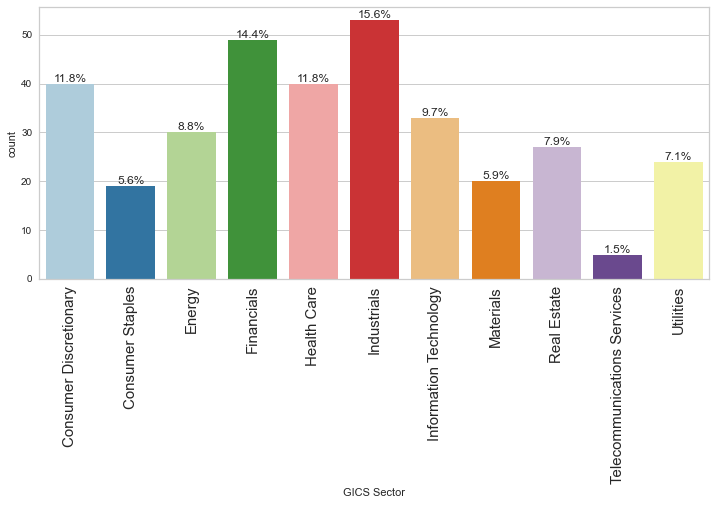

In [84]:
labeled_barplot(df, "GICS Sector", perc=True)

### Observation univariate Analysis.
1. The industrials are 15.6% of the stocks listed.
2. The financial stocks are 14.4% of the stocks listed.
3. Healthcare industry and the consumer Discretionary sector is at 11.8% of the stock segment.

In [10]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

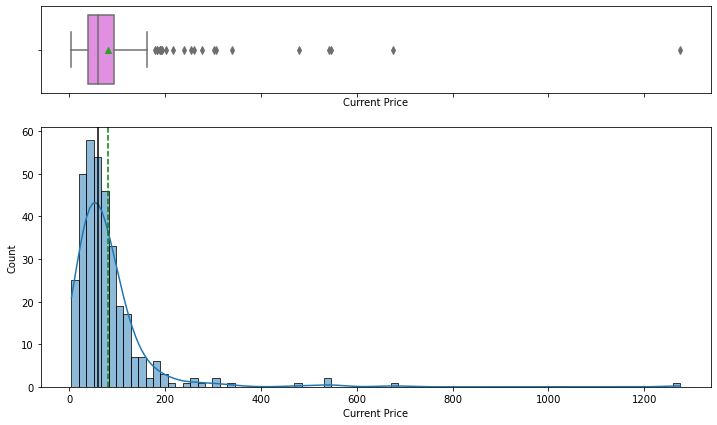

In [33]:
histogram_boxplot(df,"Current Price")

### What does the distribution of stock prices look like?

The current stock prices for the stock ticker is right skewed.The mean value of the stock is close to 80 and the median value is around 65.The price of the stock has some exterme outliers as well.

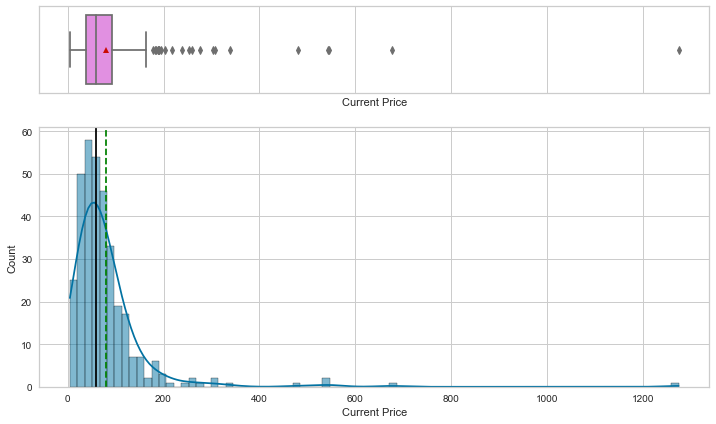

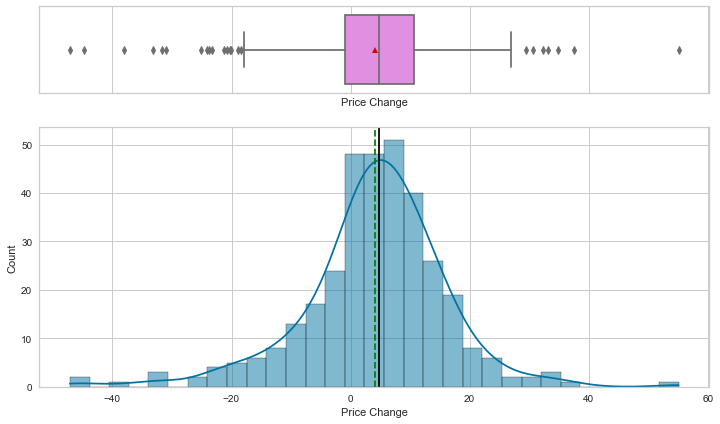

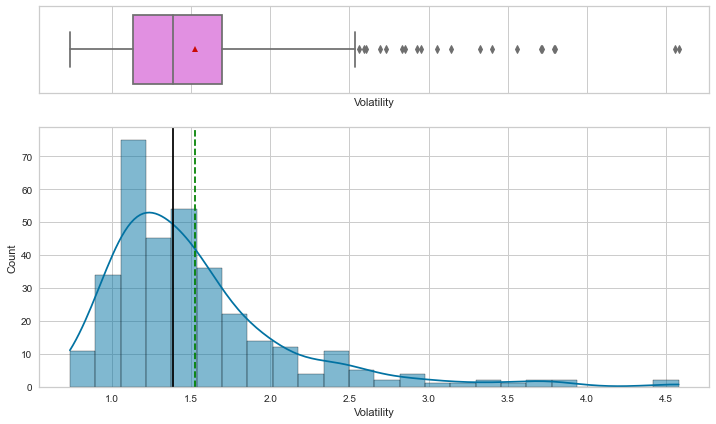

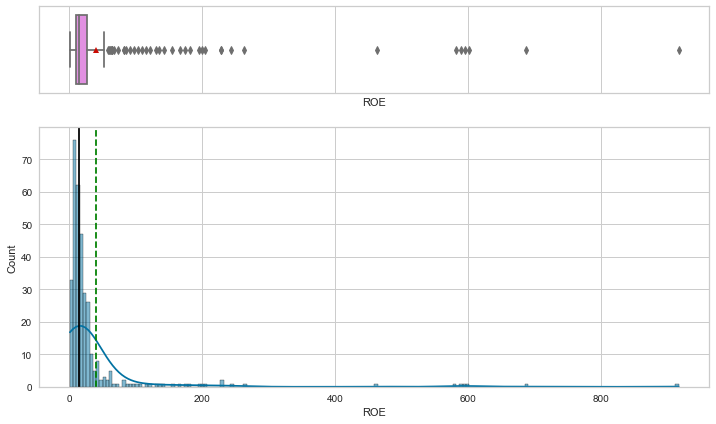

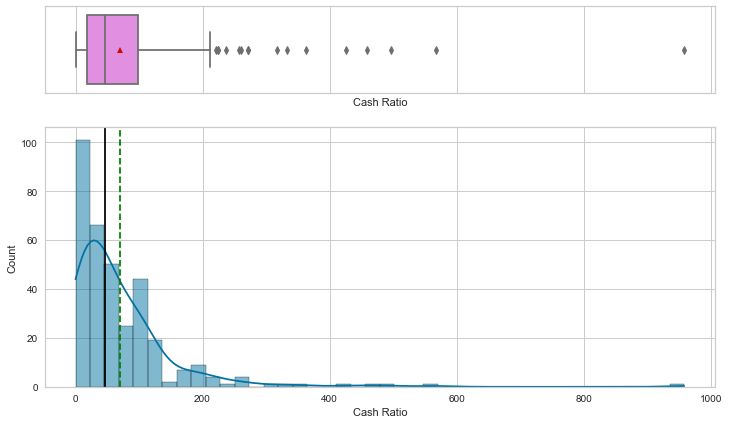

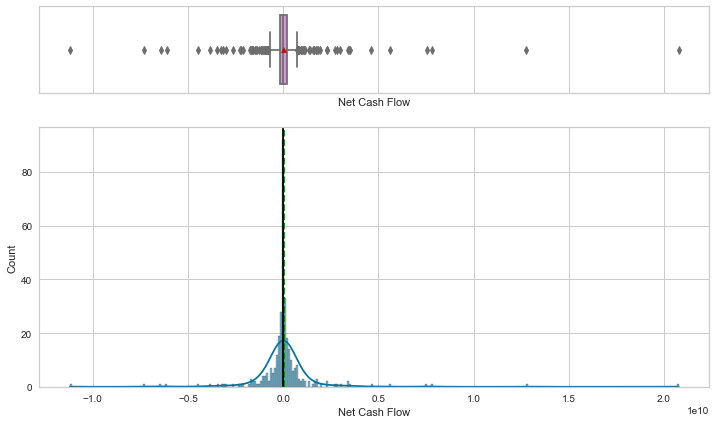

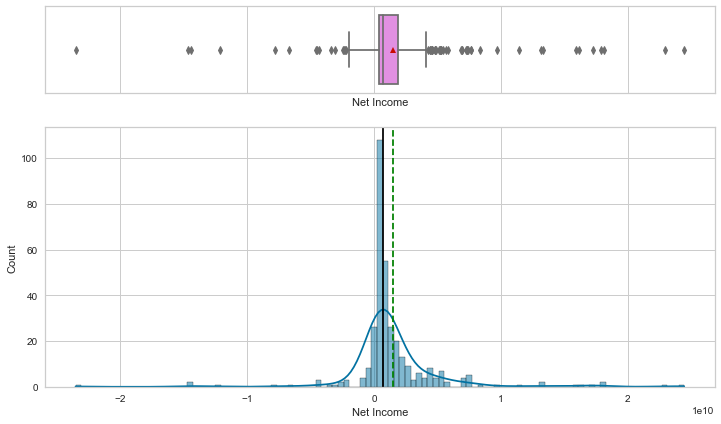

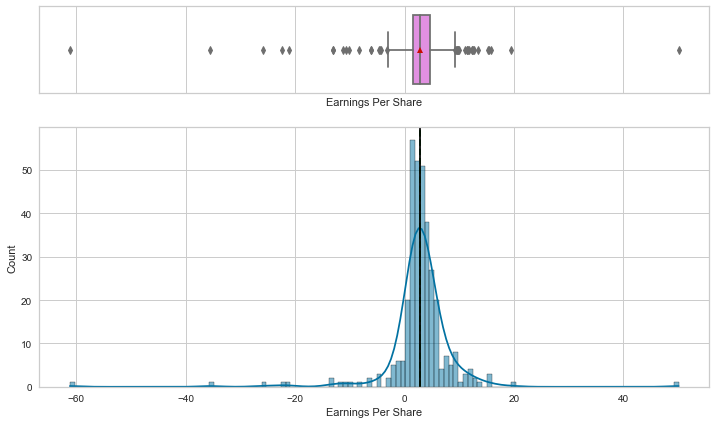

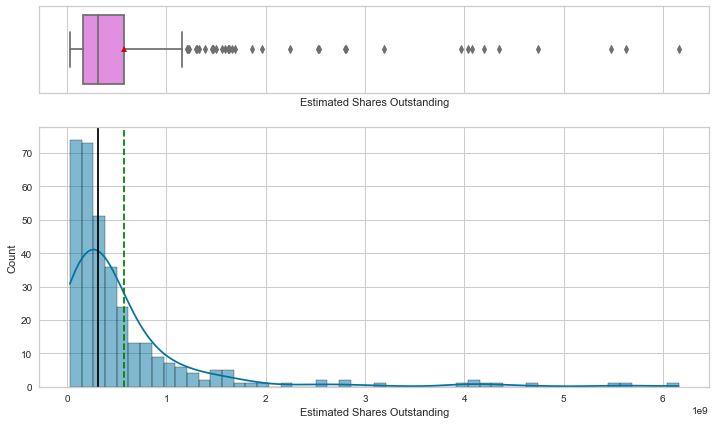

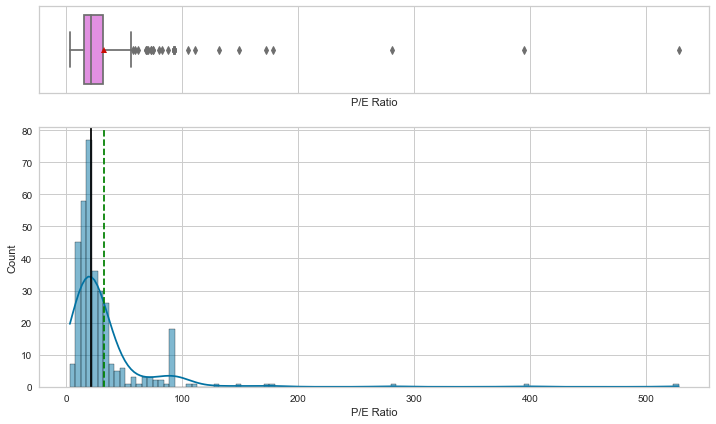

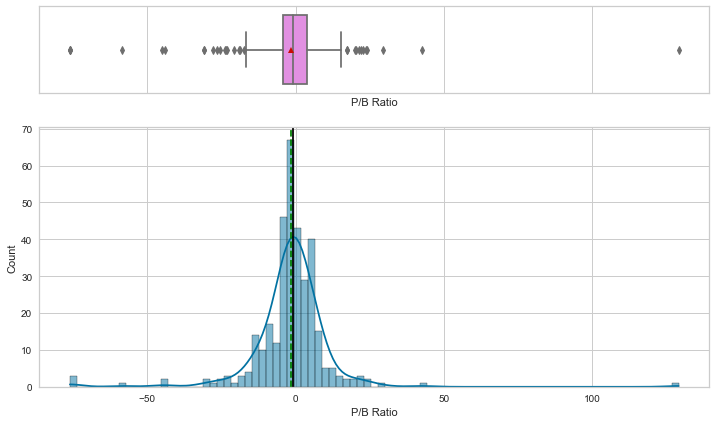

In [11]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for i in num_cols:
    histogram_boxplot(df,i,)

### Observation from Univariate Analysis.
                 
1. Volatility ,                     
2. ROE    ,                        
3. Cash Ratio ,             
4. Net Income ,                    
5. Earnings Per Share,             
6. Estimated Shares Outstanding,
7. P/E Ratio--- These columns1 thru 7 is right skewed and has outliers some are extreme.
8. Net Cash Flow -- is a normal distribution.This has a few outliers on both sides.
9. P/B Ratio -- is  normal distribution. This has few outliers on both sides.

## Bivariate Analysis

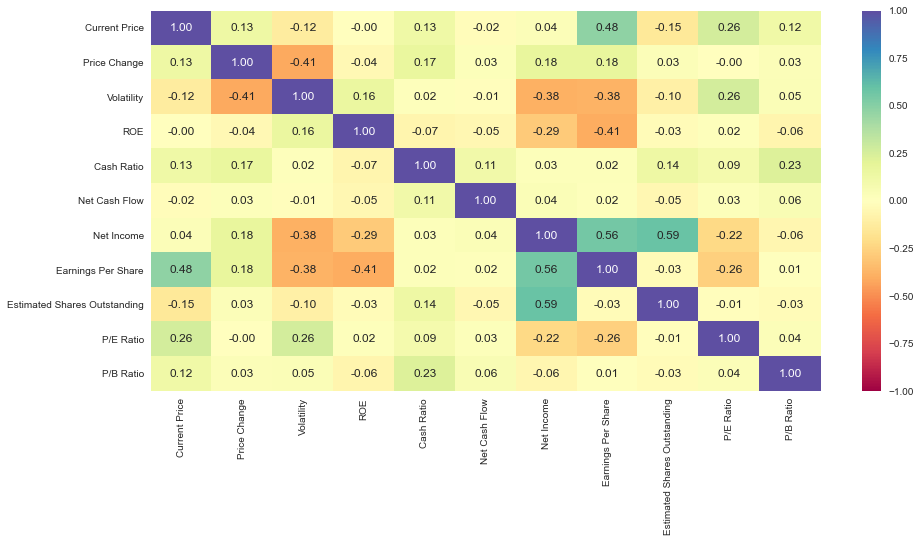

In [12]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## How are the different variables correlated with each other?

### Observations
1. Price Change and Net Income are negatively corelated with Volatility.
2. Earning per share is positively corelated to the Current price.
3. Net Income is positively corelated to both Earning Per Share and Net Shares Outstanding.
4. Net Income and Earning Per Share is negatively co-related to P/E Ratio.
5. ROE and Volatility are negatively corelated to Earning Per Share.

## The stocks of which economic sector have seen the maximum price increase on average?

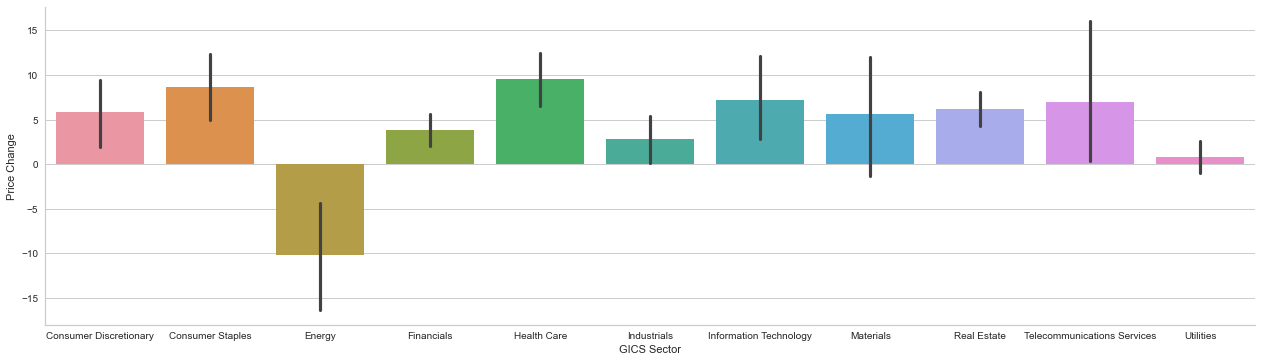

In [85]:
sns.catplot(x="GICS Sector",y="Price Change", data=df, kind='bar', height=5, aspect=3.5, estimator=np.mean);

### Observation
The health care sector has seen price increase of close to 9-10% followed by consumer staples around 7-8%.

### Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

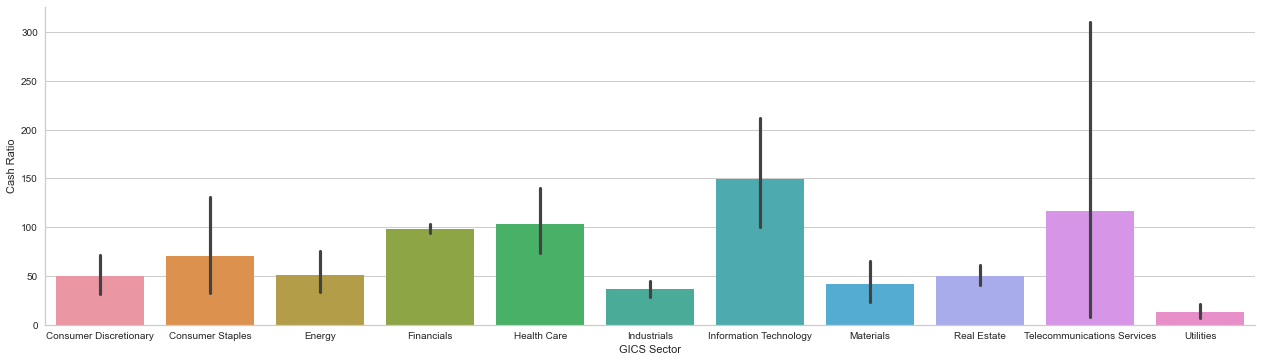

In [86]:
sns.catplot(x="GICS Sector",y="Cash Ratio", data=df, kind='bar', height=5, aspect=3.5, estimator=np.mean);

### Observation
The Information Technology sector has the highest Cash Ratio around 150 followed by Telecommunications Services at 120 and healthcare at 100.

### P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

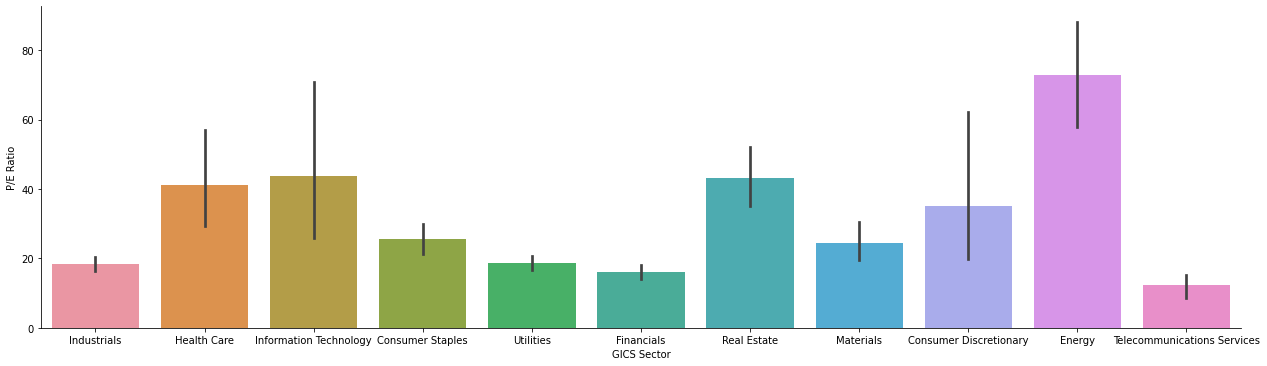

In [21]:
sns.catplot(x="GICS Sector",y="P/E Ratio", data=df, kind='bar', height=5, aspect=3.5, estimator=np.mean);

### Observation
The Energy sector has the highest P/E Ratio among ll the sectors at around 65 to 70. Followed by Information Technology at slightly more than 40 closely followed by Real Estate and Health Care around 40.

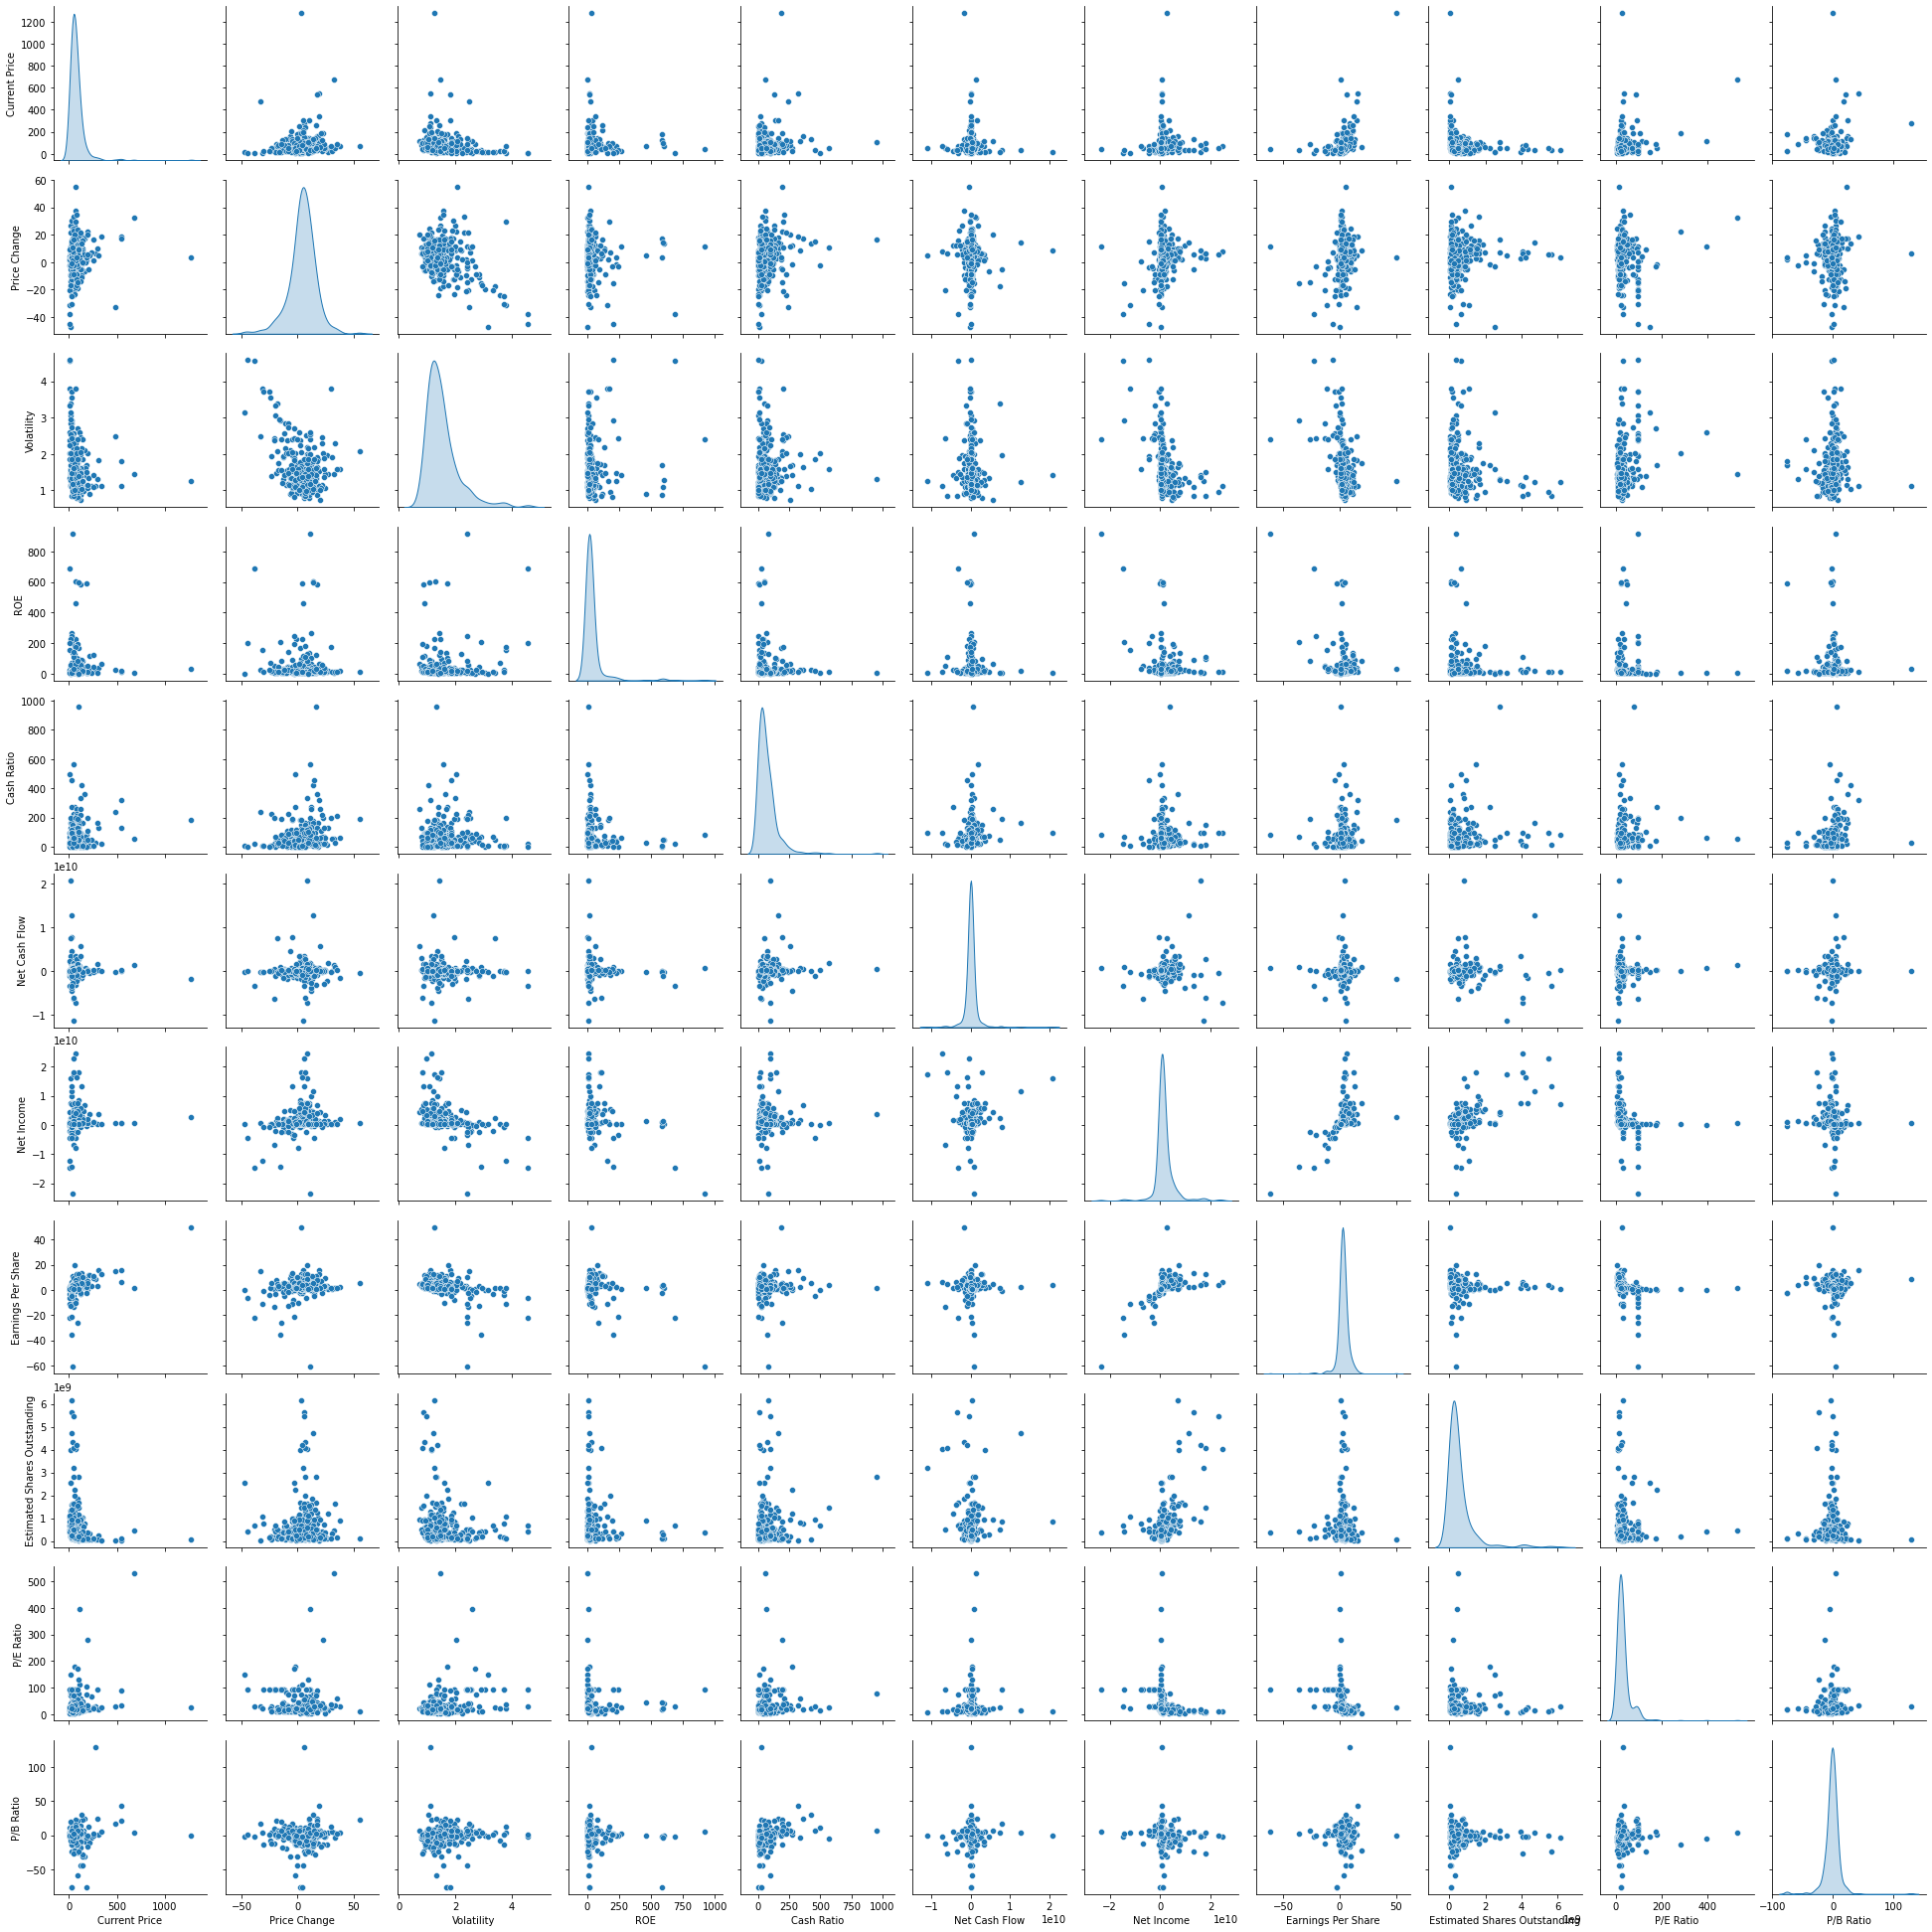

In [26]:
sns.pairplot(data=df[num_cols], diag_kind="kde")
plt.show()

### Observation
The distribution shows that there are no Gausian mixes and the data appears normal.

## Data PreProcessing

#### Missing Value treatment


In [92]:
df.isna().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
K_means_segments                0
HC_Clusters                     0
dtype: int64

In [93]:
# Let's see unique values
cols = df.columns

for col in cols:
    print("Unique values in the column '{}' are \n\n".format(col), df[col].unique())
    print("-" * 100)

Unique values in the column 'Ticker Symbol' are 

 ['AAL', 'ABBV', 'ABT', 'ADBE', 'ADI', ..., 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
Length: 340
Categories (340, object): ['AAL', 'ABBV', 'ABT', 'ADBE', ..., 'YUM', 'ZBH', 'ZION', 'ZTS']
----------------------------------------------------------------------------------------------------
Unique values in the column 'Security' are 

 ['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', 'Analog Devices, Inc.', ..., 'Yahoo Inc.', 'Yum! Brands Inc', 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis']
Length: 340
Categories (340, object): ['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Adobe Systems Inc', ..., 'Yum! Brands Inc', 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis']
----------------------------------------------------------------------------------------------------
Unique values in the column 'GICS Sector' are 

 ['Industrials', 'Health Care', 'Information Technology', 'Consumer Staples'

### Observation
 Since we are not seeing any strange values in the numerical columns(checking uniqueness) we will assume all the data negative and positive are all valid values.

#### No missing values.

In [94]:
#check for data duplication
df.duplicated().sum()

## No duplicated values

0

In [95]:
###drop columns not needed for clustering
df.drop(["Ticker Symbol","Security","GICS Sector","GICS Sub Industry"],axis=1)
df.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,HC_Clusters
0,AAL,American Airlines Group,Industrials,Airlines,42.350,10.000,1.687,135,51,-604000000,7610000000,11.390,668129938.500,3.718,-8.784,3,3
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240,8.339,2.198,130,77,51000000,5144000000,3.150,1633015873.000,18.806,-8.750,3,3
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910,11.301,1.274,21,67,938000000,4423000000,2.940,1504421769.000,15.276,-0.394,3,3
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940,13.977,1.358,9,180,-240840000,629551000,1.260,499643650.800,74.556,4.200,3,1
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320,-1.828,1.701,14,272,315120000,696878000,0.310,2247993548.000,178.452,1.060,0,3


### Outlier Check
The numerical variables all of them have outliers from the EDA(Univariate Analysis). We will not treat them as they could be valid values for this type of stock market data and the analysis we want to do.

In [96]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_cols].copy()
subset_scaled = scaler.fit_transform(subset)

In [97]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2659465936501304
Number of Clusters: 4 	Average Distortion: 2.1822426161442072
Number of Clusters: 5 	Average Distortion: 2.1312843101604906
Number of Clusters: 6 	Average Distortion: 2.078517766078626
Number of Clusters: 7 	Average Distortion: 2.03860479059637
Number of Clusters: 8 	Average Distortion: 1.9744635725476796


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

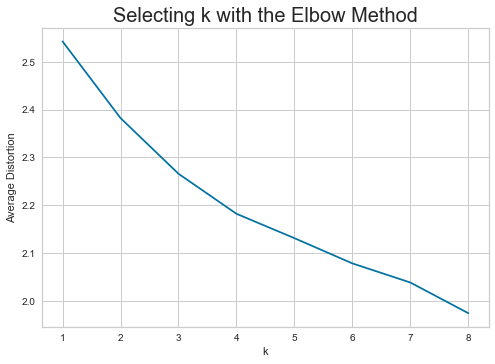

In [112]:
#K means clustering
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

### The appropriate value of k from the elbow curve seems to be 4, 5 or 6.

For n_clusters = 2, silhouette score is 0.43969639509980457
For n_clusters = 3, silhouette score is 0.45797710447228496
For n_clusters = 4, silhouette score is 0.4579748748825155
For n_clusters = 5, silhouette score is 0.4388445832681834
For n_clusters = 6, silhouette score is 0.38271795563568073
For n_clusters = 7, silhouette score is 0.4118453207204969


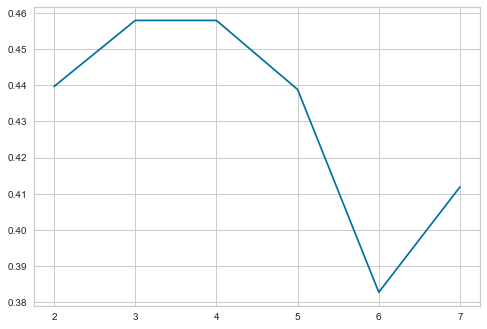

In [113]:
sil_score = []
cluster_list = list(range(2, 8))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

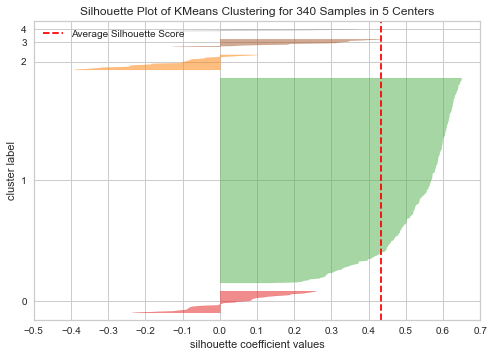

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [114]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

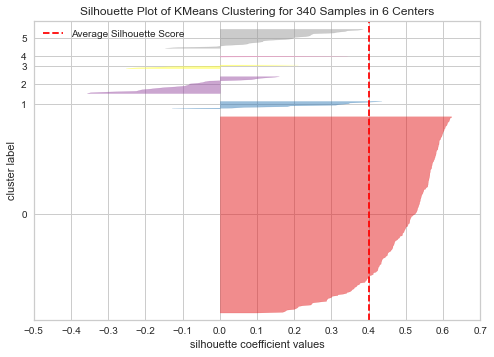

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [115]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

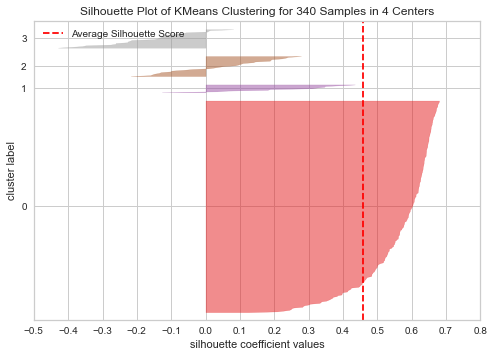

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [116]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

### let's take 4 as number of clusters

In [117]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=0)

In [118]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [119]:
cluster_profile = df.groupby("K_means_segments").mean()

In [120]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["GICS Sector"].count().values
)

In [121]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,HC_Clusters,count_in_each_segment
K_means_segments,,,,,,,,,,,,,
0,234.170932,13.400685,1.729989,25.600000,277.640000,1554926560.000000,1572611680.000000,6.045200,578316318.948800,74.960824,14.402452,1.320000,25
1,38.099260,-15.370329,2.910500,107.074074,50.037037,-159428481.481481,-3887457740.740741,-9.473704,480398572.845926,90.619220,1.342067,0.370370,27
2,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,2.000000,11
3,72.399112,5.066225,1.388319,34.620939,53.000000,-14046223.826715,1482212389.891697,3.621029,438533835.667184,23.843656,-3.358948,2.906137,277


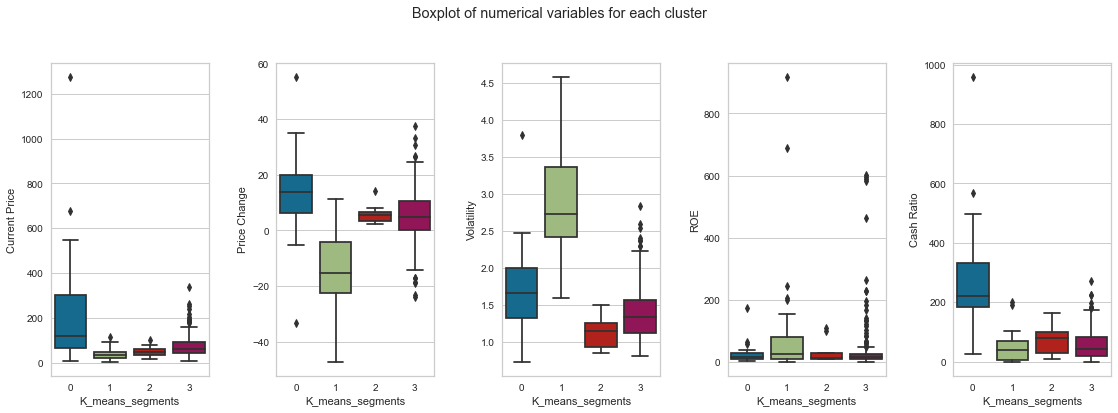

In [111]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_cols[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

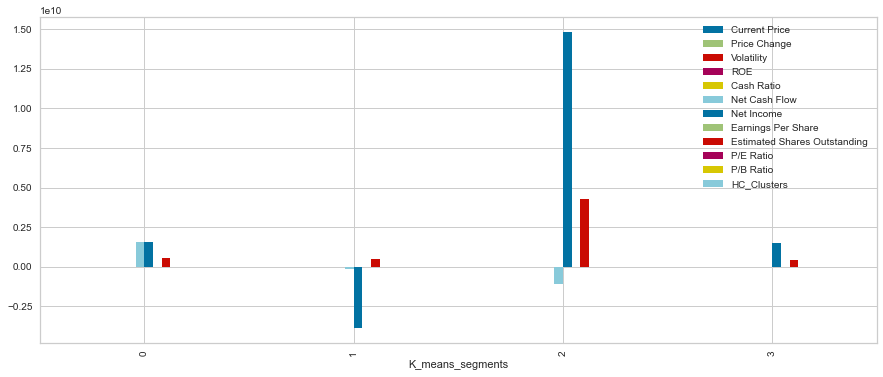

In [108]:
df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Cluster 0 from K-Means
1. The net income and the net cash flow appears to be same between 0 and 17.5%.
2. Estimated outstanding shares are higher than cluster 1.
3. EPS is the highest of all the clusters and the P/E ratio is better than cluster 1 securities.
4. P/B ratio is at 14 meaning that the stock is trading on a average 14 times more than the book value.

### Cluster 1 from K-Means
1. Net cash flow is negative.
2. Net income is also Negative.
3. Estimated outstanding shares less than cluster 0.
4. EPS is negative and highest P/E ratio(Typically not a good thing).
5. P/B ratio is very good compared to other clusters as it is trading at only 1.3 times the book value.


### Cluster 2 from K-Means
1. Net cash flow is negative and bigger than clusters 0 and cluster 1.
2. Net Income seems to be quite high, better than all the other clusters.
3. Estimated outstanding shares is the highest of all the clusters.
4. EPS is higher than other clusters but lower than cluster 0. P/E ratio is the best of all the clusters.
5. P/B ratio is negative that could indicate this cluster contains stocks that are under some financial stress. 

### Cluster 3 from K-Means
1. Net cash flow negative.
2. Net Income is positive around 17.5%.
3. Estimated outstanding shares lower than all the other clusters.
4. EPS is lower than cluster 0 and cluster 2. The P/E ratio is better than cluster 0 and 1.
6. P/B ratio is negative that could indicate this cluster contains stocks of companies that are under some financial stress. 

## Hierarchical Clustering

In [75]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524588.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.792530720285.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159736.
Cophenetic correlatio

In [76]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with Euclidean distance and average linkage.


In [77]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.


In [78]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9422540609560814, which is obtained with average linkage.


### We see that the cophenetic correlation is maximum with Euclidean distance and Average linkage.

### Let's see the dendrograms for the different linkage methods.

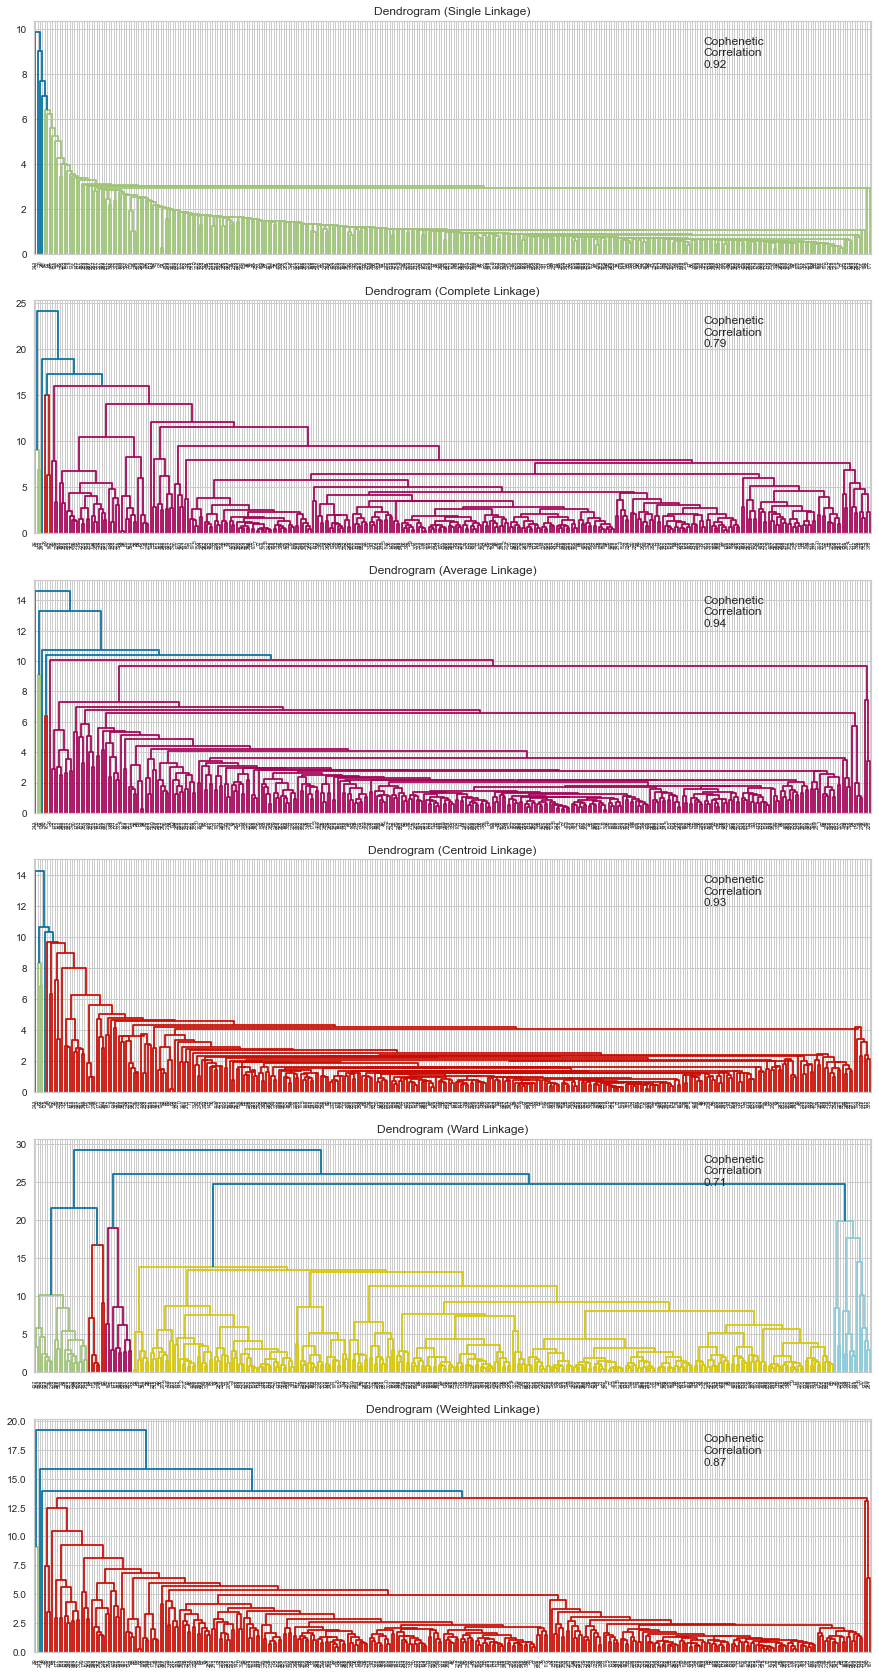

In [79]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

### Observations

1. The cophenetic correlation is highest for average and centroid linkage methods.
2. We will move ahead with average linkage.
3. 4 appears to be the appropriate number of clusters from the dendrogram for average linkage.

In [47]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [49]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling

In [51]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [53]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["GICS Sector"].count().values
)

In [59]:
# let's see the names of the Security in each cluster
for t in df["HC_Clusters"].unique():
    print("In cluster {}, the following stocks are present:".format(t))
    print(df[df["HC_Clusters"] == t]["Security"].unique())
    print()

In cluster 0, the following stocks are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co'
 'Alliance Data Systems' 'Ameren Corp' 'American Electric Power'
 'AFLAC Inc' 'American International Group, Inc.'
 'Apartment Investment & Mgmt' 'Assurant Inc' 'Arthur J. Gallagher & Co.'
 'Akamai Technologies Inc' 'Albemarle Corp' 'Alaska Air Group Inc'
 'Allstate Corp' 'Allegion' 'Alexion Pharmaceuticals'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Amgen Inc' 'Ameriprise Financial' 'American Tower Corp A'
 'Amazon.com Inc' 'AutoNation Inc' 'Anthem Inc.' 'Aon plc'
 'Anadarko Petroleum Corp' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Bank of America Corp' 'Baxter International Inc.' 'BB&T Corporation'
 'Bard (C.R.) Inc.' 'Baker Hughes Inc' 'BIOGEN IDEC Inc.

#### We see that there are 2 clusters of one security each(facebook, priceline.com), 1 cluster of two securities(both in the energy sector), and all the other securities are grouped into another cluster. This clustering does not look good as the clusters do not have enough variability.



#### Let us try using Ward linkage as it has more distinct and separated clusters (as seen from it's dendrogram before). 4 appears to be the appropriate number of clusters from the dendrogram for Ward linkage.

In [60]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=4)

In [63]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

### Cluster Profiling

In [64]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [65]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["GICS Sector"].count().values
)

In [66]:
# let's see the names of the Security in each cluster
for t in df["HC_Clusters"].unique():
    print("In cluster {}, the following stocks are present:".format(t))
    print(df[df["HC_Clusters"] == t]["Security"].unique())
    print()

In cluster 3, the following stocks are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co' 'Ameren Corp'
 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'AMETEK Inc'
 'Affiliated Managers Group Inc' 'Ameriprise Financial'
 'American Tower Corp A' 'AutoNation Inc' 'Anthem Inc.' 'Aon plc'
 'Amphenol Corp' 'Arconic Inc' 'Activision Blizzard'
 'AvalonBay Communities, Inc.' 'American Water Works Company Inc'
 'American Express Co' 'Boeing Company' 'Baxter International Inc.'
 'BB&T Corporation' 'Bard (C.R.) Inc.' 'BIOGEN IDEC Inc.'
 'The Bank of New York Mellon Corp.' 'Ball Corp' 'Bristol-Myers Squibb'
 'Boston Scientific' 'BorgWarner' 'Boston Properties' 'Caterpillar Inc.'
 'Chubb Limited' 'CBRE Group' 'Crown Castle International Corp.'
 'Ca

#### After using ward method the clustering makes sense and it has some variability. 

In [67]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,,,,,,,
0,48.006208,-11.263107,2.590247,196.551724,40.275862,-495901724.137931,-3597244655.172414,-8.689655,486319827.294483,75.110924,-2.162622,1.413793,29
1,213.518640,15.252913,1.779861,22.333333,258.740741,1504052814.814815,1716529851.851852,5.177407,689838338.441482,78.441603,13.022590,0.555556,27
2,46.672222,5.166566,1.079367,25.000000,58.333333,-3040666666.666667,14848444444.444445,3.435556,4564959946.222222,15.596051,-6.354193,2.000000,9
3,72.421687,4.563230,1.403434,25.218182,55.014545,72801872.727273,1572467469.090909,3.728564,445003946.148763,24.188244,-2.966949,2.930909,275


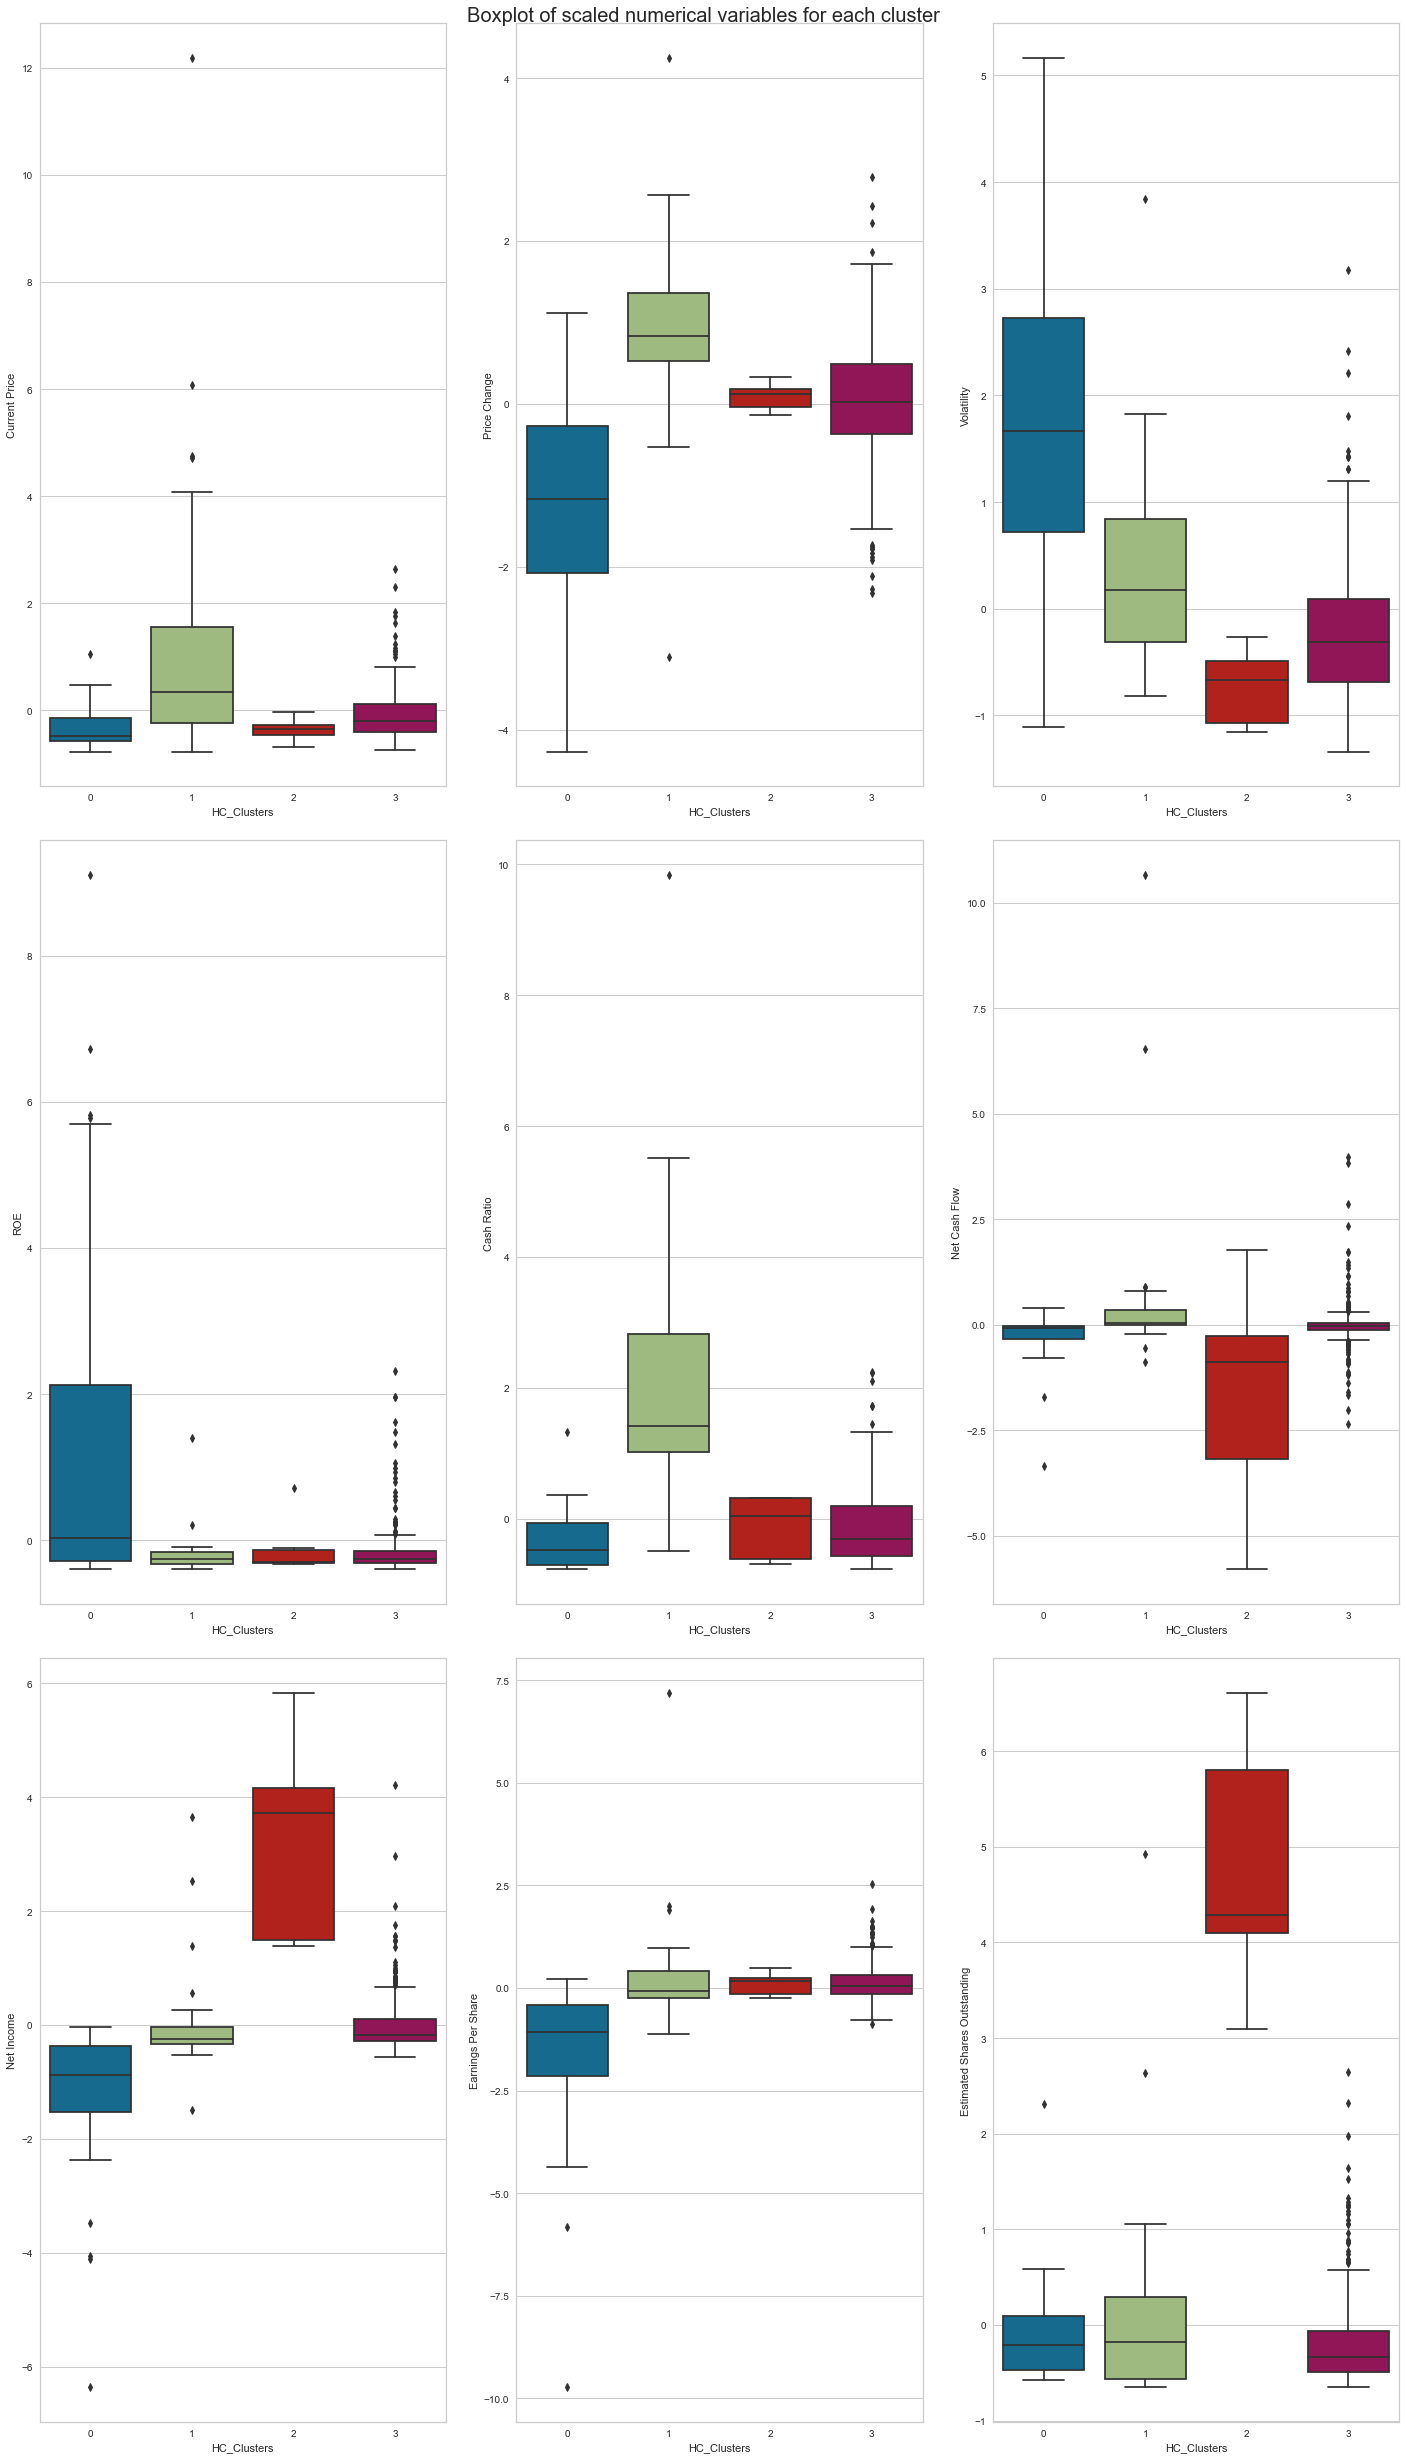

In [89]:
fig, axes = plt.subplots(3, 3, figsize=(20, 35))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(3):
    sns.boxplot(
        ax=axes[ii][0],
        y=subset_scaled_df[num_cols[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=subset_scaled_df[num_cols[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=subset_scaled_df[num_cols[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

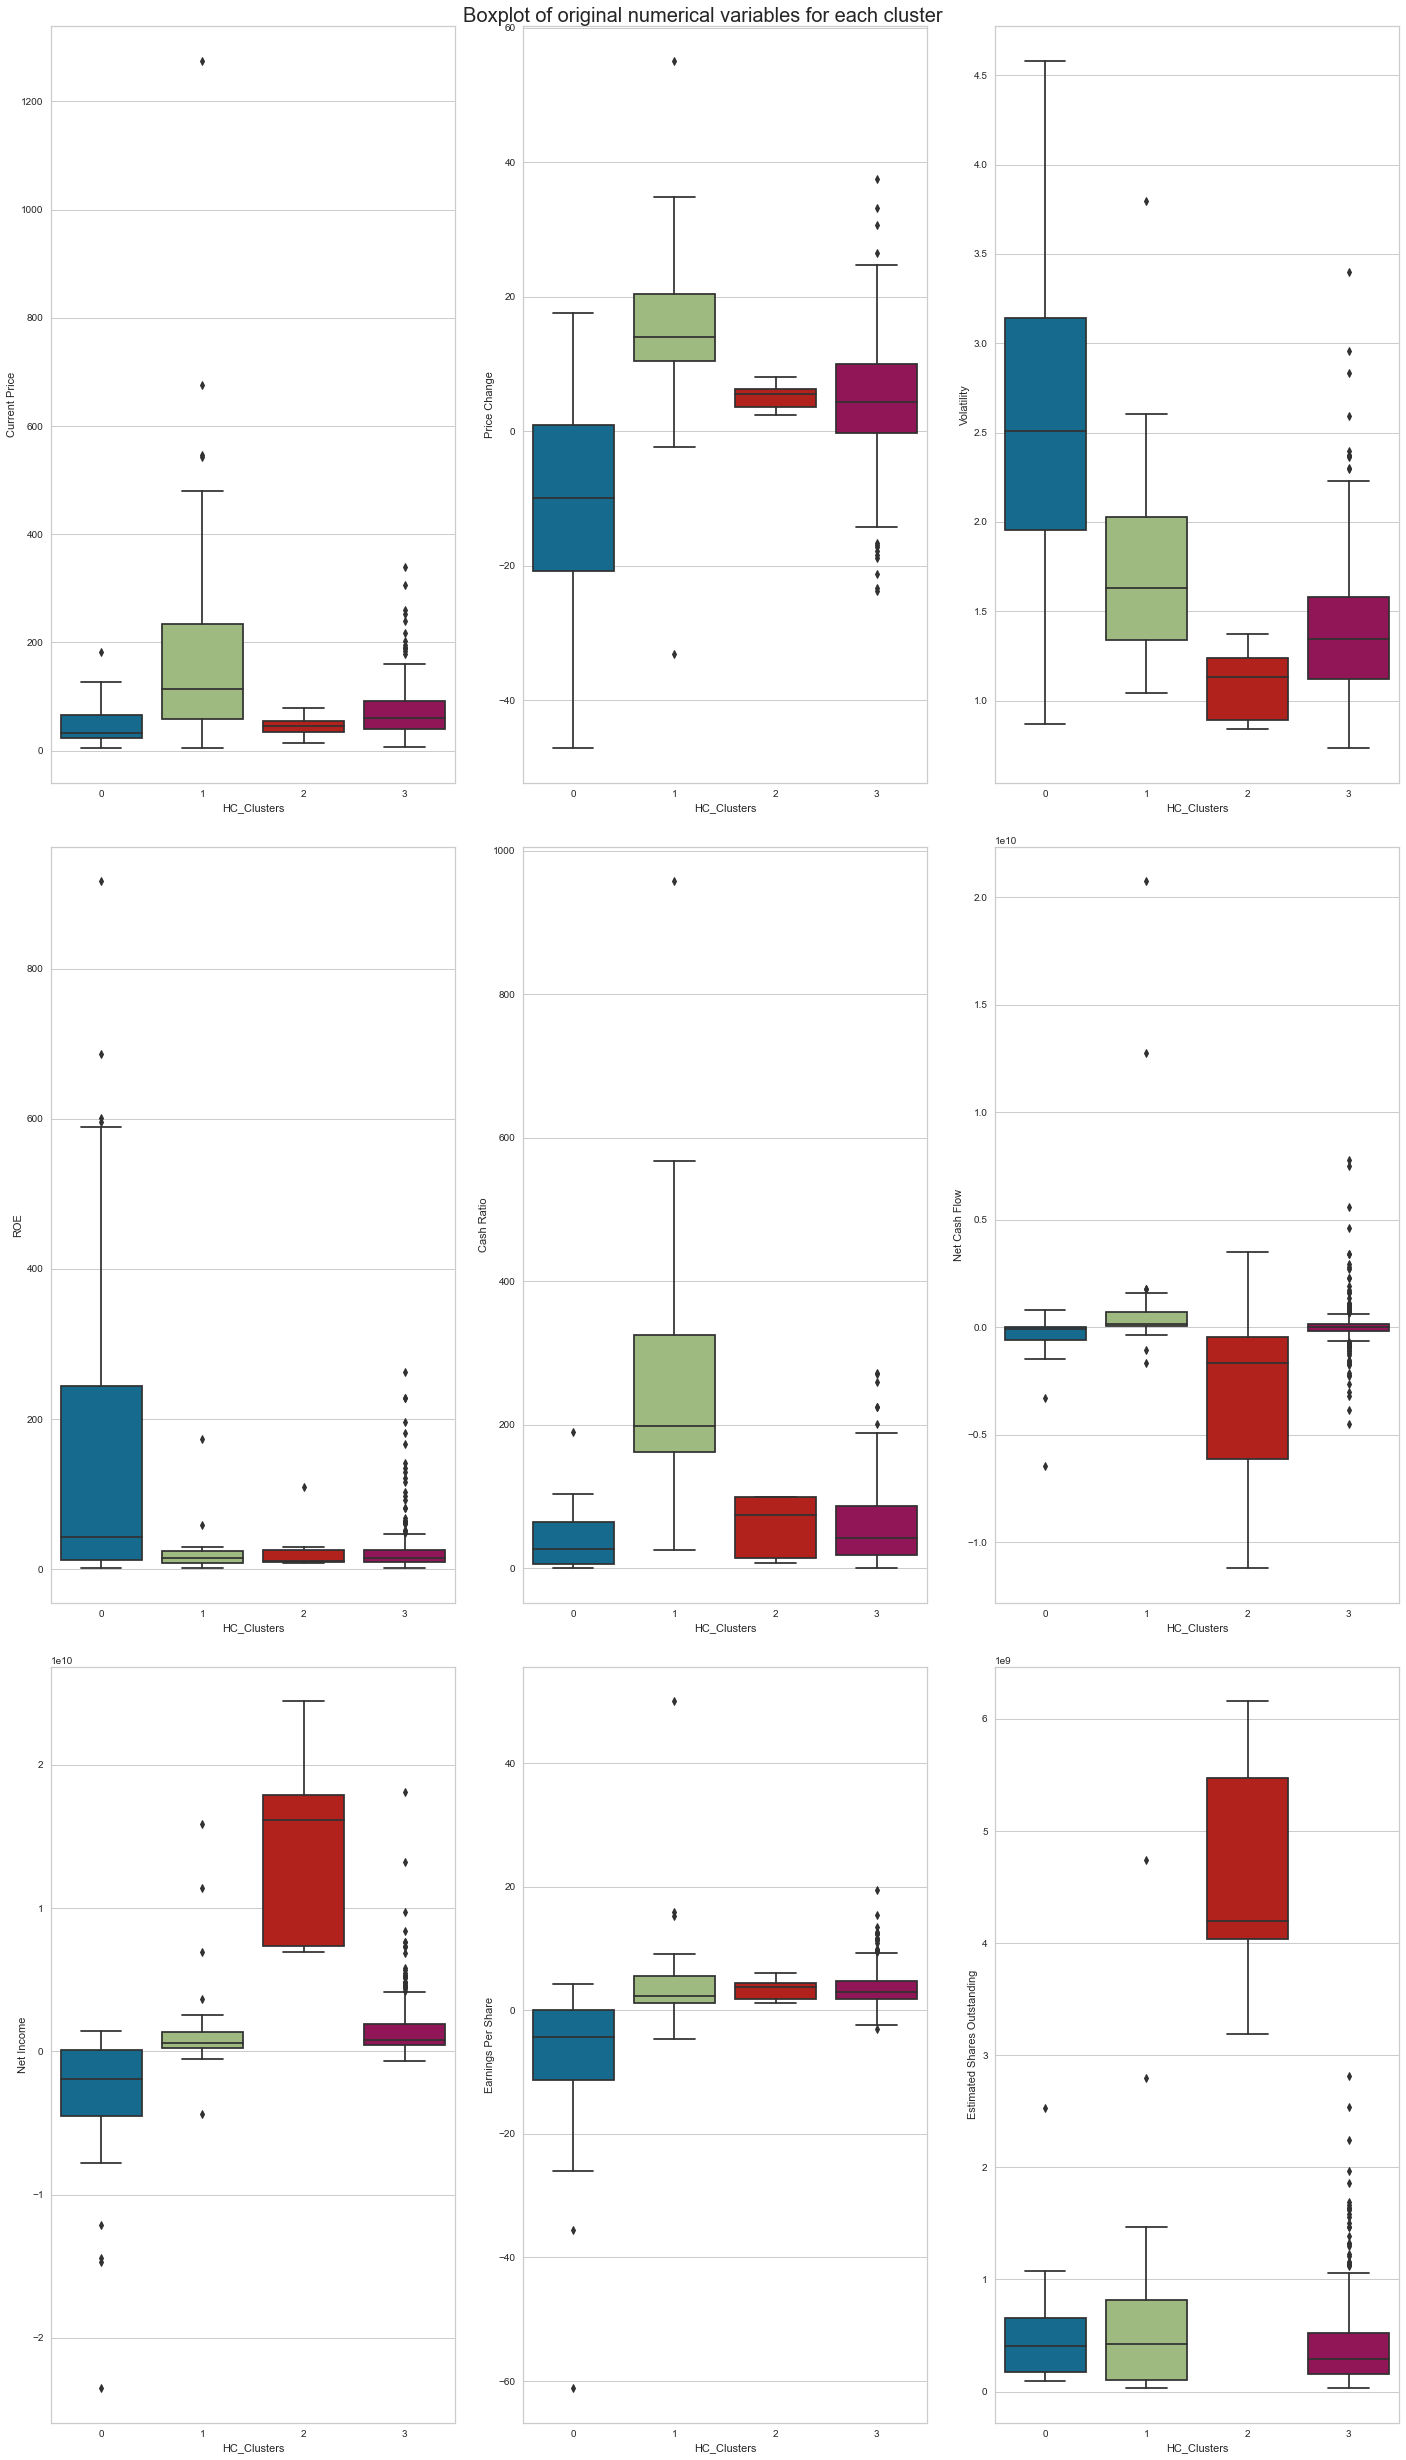

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(20, 35))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(3):
    sns.boxplot(
        ax=axes[ii][0],
        y=df[num_cols[counter]],
        x=df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=df[num_cols[counter]],
        x=df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=df[num_cols[counter]],
        x=df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

## K-means vs Hierarchical Clustering

1. From the Elbow chart it was difficult to guess which one would be the right value of k, we had potential values of k=4 or 5 or 6.
2. Finally settled on k=4 which seems to give well defined clusters.
3. In HC we first used the Agglomorative clustering ,Highest cophenetic correlation is 0.9422540609560814, which is obtained with Euclidean distance and average linkage. But the clusters formed this method was not well defined we got 2 clusters of just one security and 1 cluster of 2 securities and rest of the 336 security were lumped into one.
4. we then used the Ward linkage as it has more distinct and separated clusters (as seen from it's dendrogram ). This helped us to get varied clusters that made sense.
5. Both of these methods look for similarities in the data to come up with the recommended clusters.We need to use both k-means and HC to get a good understanding of the data and then derive conclusions based on both the methods.
6. If we have a huge dataset then Using HC would be difficult due to performance issues.K-Means is not bogged down by a large dataset.

## Insights

We have 4 as the number of clusters for this study.

### Cluster 0

1. Cluster 0 has 29 Ticker symbols.
2. This is comprised primarily of the Energy Sector like (Chesapeake Energy,Anadarko Petroleum Corp,Cimarex Energy) to name a few.
3. we also see consumer staples that is needed for everyday living like (Kimberly-Clark,Colgate-Palmolive) to name some.
4. These two sectors have P/E ration at 75, but some are more reasonable between 8 and 10.
5. These two sectors Energy sector has more votility than the and the consumer staples as less volatilty.
6. The ROE for this cluster for Energy ticker's is very high many give > 10% returns. some even more than 200%. This could be the sector for an investor who is interested in getting good ROE.The consumer staples also gives out good ROE many greater than 10%.
7. EPS -- The consumer staples industry show positive earning's per share 3.5 or greater. The Energy sector shows a negative EPS showing that the stocks are positive but earning are negative due to the market being forward looking.
8. P/B ratio is negative that could indicate this cluster contains stocks of companies that are under some financial stress. 
This cluster can be recommended to clients who are not too concerned with volatility and are more focused on ROE and long term forward looking benefits.

### Cluster 1

1. This cluster primarily comprises of the Technology industries and some others like Pharmaceuticals. we have 27 companies in this cluster.
2. The current Price of the stocks that belong to this cluster is quite high compared to other clusters.
3. This cluster shows less volatility than cluster 0.This sector can be recommended to clients that are averse to too much volatility.
4. These two sectors have a higher P/E ratio at 78.
5. The EPS is at 5%.
6. ROE for this cluster of companies is less compared to cluster 0. This is at 22.
7. The net cash flow for this cluster is highest of the 4 clusters. 
8. P/B is at 13 so it is trading at 13 times its book value so slightly expensive stocks in this cluster.
This cluster can be recommended to clients who are averse to too much volatility. This will give a decent EPS and ROE is good at 22.

### Cluster 2

1. This cluster primarily consists of 9 companies.Few Banks and Communications sector and other are manufacturing(cars and food). one pharmaceutical company as well.
2. This cluster is a small group of companies the volatility is low.
3. The price of each stock is not too expensive.
4. The EPS is at lower end.
5. Net income  of the securities in this cluster is better than the other clusters.
6. ROE is at an avg 25, better than cluster1.
7. P/E is more reasonable at 15% compared to the previous 2 clusters that are very high.
8. P/B ratio is negative that could indicate this cluster contains stocks of companies that are under some financial stress. 
This cluster represents more of a sector where the risks are not high and the rewards are not high either.The volatiltiy is also low.

### Cluster 3

1. This cluster forms the majority of the companies. This is huge cluster consisting of 275 companies. 80% of the stock tickers fall in this group.These belong to all the sectors in the "GICS Sector".
2. This provides a wide variety of choices for the average customer who want to invest in the stock market.
3. The ROE and EPS is better than the stocks in the cluster 2.
4. This cluster has the least price change compared to the other clusters.
5. The P/E ratio is high, but individual stocks of companies maybe different that the avarage P/E.
6. P/B ratio is negative that could indicate this cluster contains stocks of companies that are under some financial stress. 
This is best cluster to pick stocks from for investors as the wide variety of sectors are available to pick from to diversify the portfolio and shows more resiliency to temporary fluctuations (volatility is low compared to cluster 0 and 1) and will be beneficial in the long run.